# Data Analytic Tool/Package Used

Below are the basic libraries used for data analytics.

In [3]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

For visualization of the information extracted from data, the libraries in below are used. The Python Shapefile Library (pyshp) was used for read and write support of the ESRI Shapefile format. 

Matplotlib was used to produce publication quality figures in a variety of hardcopy formats and interactive environments across platforms.


In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Dataset

The information and download links of NYC Taxi Data can be found in the link below:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Here we use Python code to download data from January 2019 to December 2019 for "Yellow Taxi", "Green Taxi", "FHV" and "FHVHV".

Because of the unusual disruption in social activities in 2020, I decided to use data from 2019 to evaluate 'normal' level of activties. Here, we will closely examine our data from "Yellow Taxi" and "FHVHV" for Uber Air's case. ("Green Taxi" and "FHV" are not as relevant.)  


In [22]:
# Download the Trip Record Data
for month in range(2,13):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "fhvhv_tripdata_2019-{0:0=2d}.csv".format(month), 
                               "fhvhv_nyc.2019-{0:0=2d}.csv".format(month))



# Ran this for each groups: fhv, fhvhv, green_taxi, yellow_taxi


In [ ]:
# Download the location Data
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

## Trip Record

The yellow taxi trip records include fields capturing:

- Vendor ID
- pick-up and drop-off dates/times
- pick-up and drop-off locations
- trip_distance
- passenger count
- itemized fares
- rate types
- payment types


In [27]:
df = pd.read_csv("data/yellow_taxi/yellow_nyc.2019-07.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2019-07-01 00:51:04,2019-07-01 00:51:33,1,0.00,1,N,193,193,1,2.5,0.5,0.5,1.14,0.00,0.3,4.94,0.0
1,2,2019-07-01 00:46:04,2019-07-01 01:05:46,1,4.16,1,N,234,25,2,16.5,0.5,0.5,0.00,0.00,0.3,20.30,2.5
2,1,2019-07-01 00:25:09,2019-07-01 01:00:56,1,18.80,2,N,132,42,1,52.0,0.0,0.5,11.75,6.12,0.3,70.67,0.0
3,2,2019-07-01 00:33:32,2019-07-01 01:15:27,1,18.46,2,N,132,142,1,52.0,0.0,0.5,11.06,0.00,0.3,66.36,2.5
4,1,2019-07-01 00:00:55,2019-07-01 00:13:05,0,1.70,1,N,107,114,1,9.5,3.0,0.5,2.00,0.00,0.3,15.30,2.5


## Database

In order to deal with the large scale of data (5GB+ for 12 months of data), a database is needed. Here I am use SQLAlchemy, which is a Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.

In [10]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

### Uploading the trip record data into the database chunk by chunk

Column(6) had mixed types of data caused by NaNs. Column(6) is "SR_Flag" data is "store and forward flag", which addresses vehicle's connection to the server. This column wasn't used in the analysis.


In [29]:
j, chunksize = 1, 100000
for month in range(1,13):
    fp = "data/yellow_taxi/yellow_nyc.2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df.index += j
        df.to_sql('yellow_taxi', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Location Data

Location data includes TLC taxi zone location IDs, location names and corresponding boroughs for each ID. A shapefile containing the boundaries for the taxi zones can be found here:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

This website is useful to extract latitude/longitude of each region:

https://mygeodata.cloud/converter/shp-to-latlong

### Exploring Shapefile

Shape file taxi_zones.shp has fields ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'] in sf.fields and attributes in sf.records()


In [11]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [328]:
df_loc[df_loc['zone'] == 'JFK Airport']
# df_loc[df_loc['zone'] == 'LaGuardia Airport']

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
131,132,0.245479,0.002038,JFK Airport,132,Queens,1.042628e+06,173494.353508


### Helper Functions for Drawing Maps

In [8]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [7]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [6]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [5]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

### Maps of NYC Bouroughs & Taxi Zones

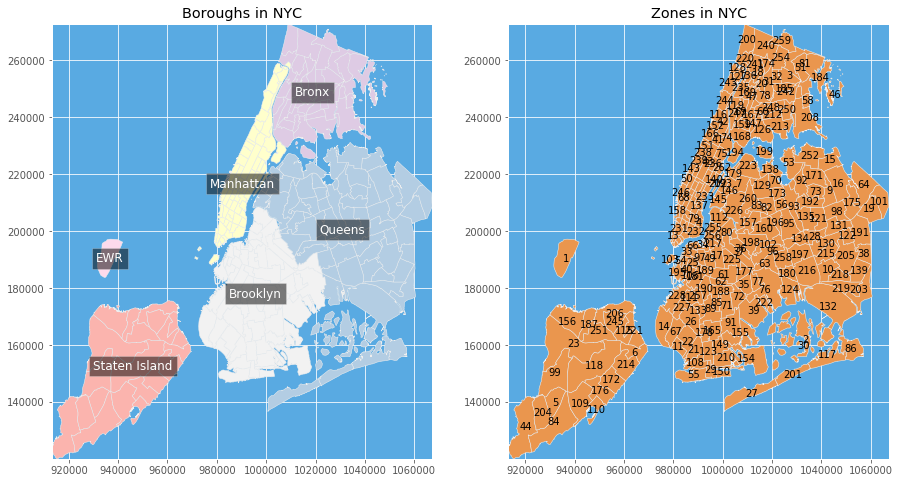

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

# NYC Yellow Taxi

## Locations - Which zones have most pickups and drop-offs?
Selecting location of pickup/dropoff and their counts from database

In [14]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM yellow_taxi \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM yellow_taxi \
                        GROUP BY DOLocationID', nyc_database)


With selected data, we find the zones with most pickups and drop-offs.

In [15]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))


Table below shows the top 5 zones for 2019

- Top 5 pickup zones are: 
    * Upper East Side South 
    * Midtown Center 
    * Upper East Side North 
    * Midtown East 
    * Penn Station/Madison Square West 
    They are all in the Upper Middle East side of Manhattan.

- Top 5 drop-off zones are: 
    * Upper East Side North 
    * Midtown Center 
    * Upper East Side South 
    * Murray Hill and Times Square/Theatre District 
    They are also mostly in Upper Middle East side of Manhattan.
    

In [16]:
PUtop5 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(5)
PUtop5

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237.0,3451728.0,3086341.0,6538069.0,Upper East Side South,Manhattan
161.0,3255357.0,3086726.0,6342083.0,Midtown Center,Manhattan
236.0,3113363.0,3242965.0,6356328.0,Upper East Side North,Manhattan
162.0,2875908.0,2414153.0,5290061.0,Midtown East,Manhattan
186.0,2865019.0,2065346.0,4930365.0,Penn Station/Madison Sq West,Manhattan


In [17]:
DOtop5 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(5)
DOtop5

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236.0,3113363.0,3242965.0,6356328.0,Upper East Side North,Manhattan
161.0,3255357.0,3086726.0,6342083.0,Midtown Center,Manhattan
237.0,3451728.0,3086341.0,6538069.0,Upper East Side South,Manhattan
170.0,2459304.0,2497068.0,4956372.0,Murray Hill,Manhattan
230.0,2741224.0,2464141.0,5205365.0,Times Sq/Theatre District,Manhattan


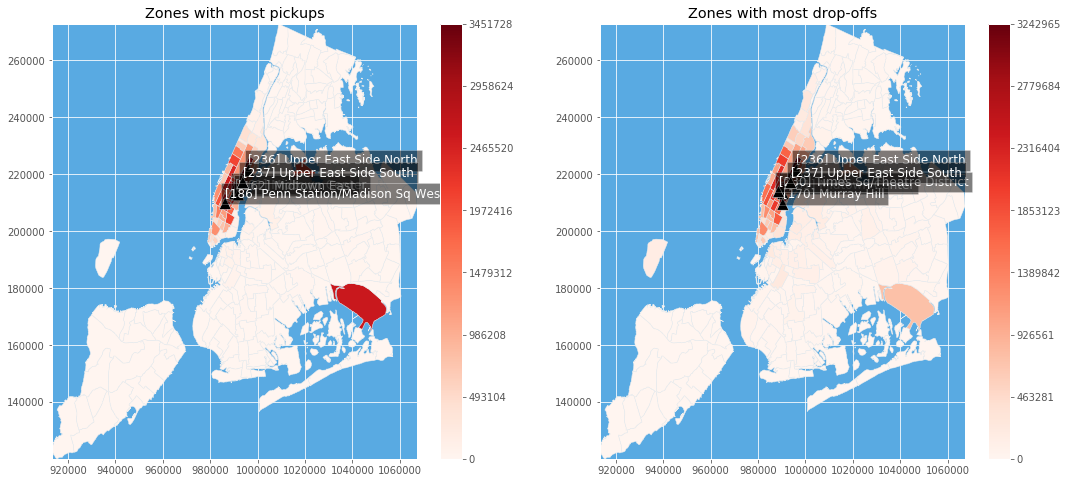

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop5.index.tolist())

From the figures above, we can see that despite the top 5 pickup/dropoff zones, many other zones in Manhattan are also popular.  

The zone in the lower-right corner that shows quite high number of demans is Queens, where JFK Airport is located. JFK is ranked at 7th pick-up location and 38th drop-off location among top 50 zones. La Guardia Air port ranks at the 14th in pick-up locations and 35th in drop-off locations. Rest of top 50 zones were in Manhattan. 

So I investigated boroughs with most pickups and drop-offs. In the tables below, we can see that Manhattan is obviously the most popular borough and Staten Island is the least popular borough. Queens and Brooklyn are also popular, although their pickup/droppoff count is less than 10% of Manhattan’s. This could be due to "Green Taxi", which are allowed to pick up passengers in northern Manhattan (north of West 110th street and East 96th street), and anywhere in the Bronx, Brooklyn, Staten Island and Queens (excluding the airports).

In [48]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

,borough,PUcount,DOcount,TOTALcount
3,Manhattan,72353067.0,70602688.0,142955755.0
4,Queens,5596103.0,4313760.0,9909863.0
1,Brooklyn,942218.0,3300853.0,4243071.0
0,Bronx,142466.0,555199.0,697665.0
2,EWR,8324.0,167541.0,175865.0
5,Staten Island,3365.0,21833.0,25198.0


In [49]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

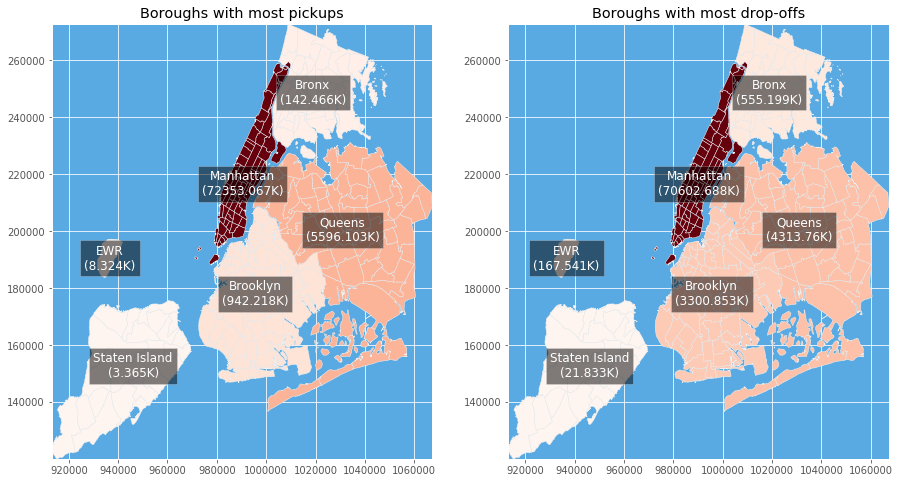

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

## Note to self: FVHHV should be investigated to see if their trips are in and out of further locations



## Time - When are the Peak hours and Off hours?

Selecting hours of pickup/dropoff and their counts from database

In [60]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM yellow_taxi \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM yellow_taxi \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

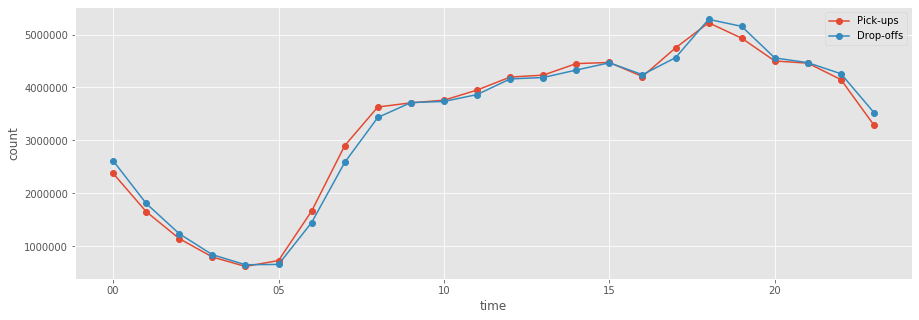

In [63]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()


As shown in the figure above, 

- Peak hour is 6PM
- Off hour is 4AM
- Active hours are from 7AM to 11PM



## Trip Distance - How far are they traveling?

To get a closer look at the distribution of trip distance, we select the trip_distance column values and print out its summary statistics.


In [43]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM Yellow_Taxi WHERE trip_distance > 0', nyc_database)
df_dist['trip_distance'].describe()


count    7.910166e+07
mean     3.031037e+00
std      6.846007e+00
min      1.000000e-02
25%      1.000000e+00
50%      1.650000e+00
75%      3.090000e+00
max      4.597722e+04
Name: trip_distance, dtype: float64

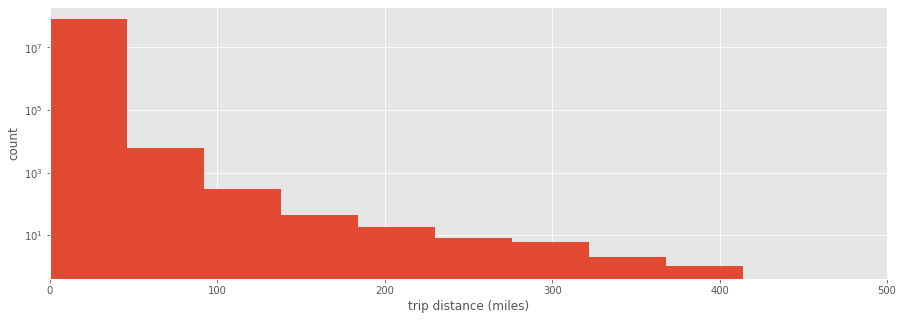

In [44]:
ax = df_dist['trip_distance'].hist(bins=1000, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlim(0, 500)
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

## Short vs Long distance

The distribution of trip_distance is extremely right skewed as shown in the figure above. As there were some extreme outliers, the figure's x limit is set to 500 miles. Y axis is set at log scale.


Considering that the landmass of New York City is 302.6 square miles, the figure above should represent most trips taking place within the area. Now, total area of Manhattan is 33.58 square miles. That number should let us split the trips into short and long distance groups.  

In [61]:
df_dist_short = df_dist[df_dist['trip_distance'] < 34]
df_dist_long = df_dist[df_dist['trip_distance'] >= 34]

print("Short Trips: {} records in total. \nLong Trips: {} records in total."
     .format(len(df_dist_short), len(df_dist_long)))

Short Trips: 79077239 records in total. 
Long Trips: 24423 records in total.


More than 99% of trips are short distance trips. 

Fare price... how much is long distance?
Uber Air is $5 per mile
Taxi Fare Manhattan $59(Newark, JFK), $49(LaGuardia)
distance: jfk(14.1 miles), LGA(5.1 miles), Newark(12.4 miles)

Uber Air's initial launch

## Temporal Differences

Uber Air would be better suited to serve long distance. Here we observe the difference in temporal attributes for both short and long distances.

To see the difference in pickup & dropoff time, we are selecting temporal information from the database.

In [80]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance < 34 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance >= 34 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)


## Helper Codes

In [84]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [82]:
def diff_short_long_trip_on_time():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

Visualize the pickup/dropoff counts at each time for short trips and long trips.

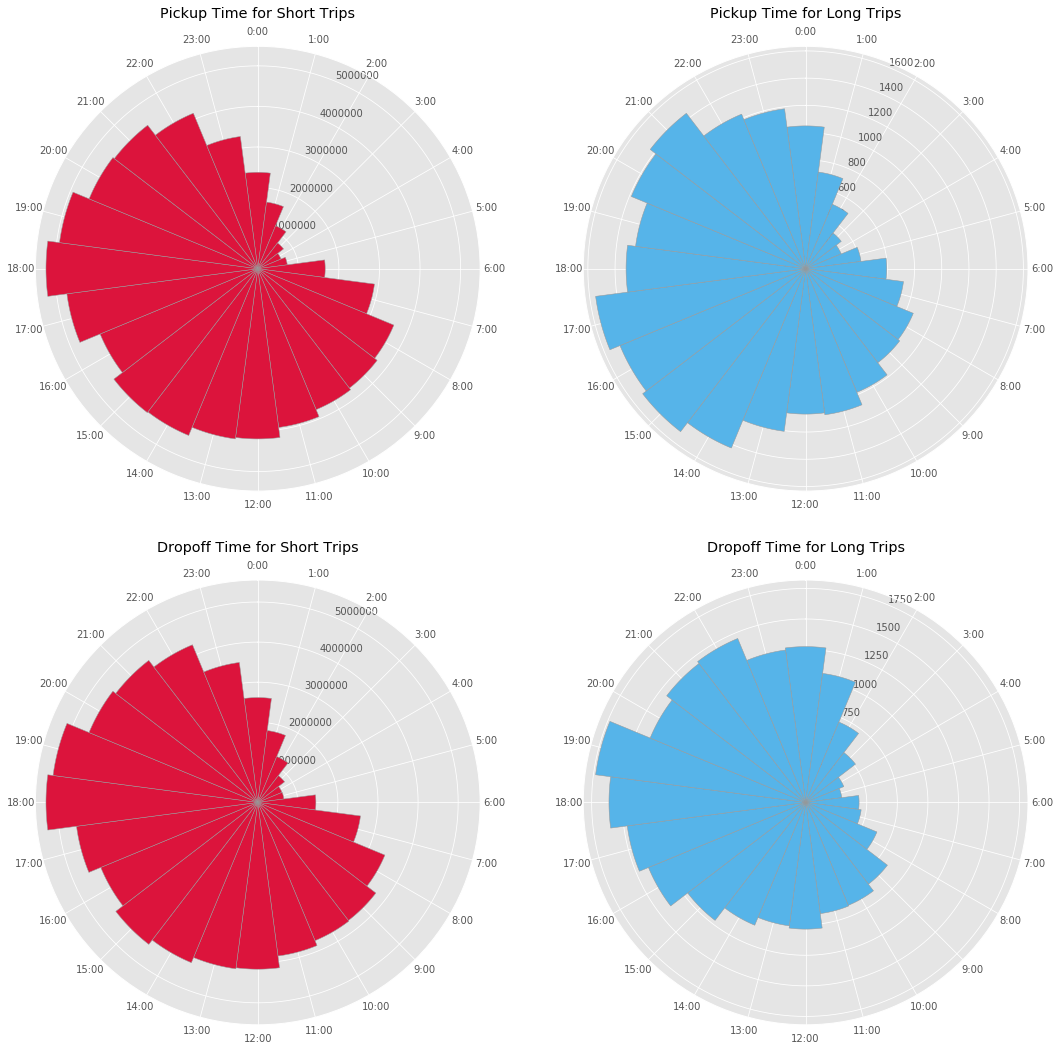

In [85]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})

df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")

diff_short_long_trip_on_time()

From the figure above, we can observe that

1. Short Trips
    * the hours of robust activity are from 9AM to 10PM
    * the peak hours are from 6PM to 7PM


2. Long Trips
    * the hours of robust activity are from 9AM to 10PM
    * the peak hours for pickups are from 2PM to 6PM
    * the peak hours for dropoffs are from 4PM to 7PM


3. Off hours are from 11PM to 8AM



## Spatial Differences

Let's examine where the passengers are going by summarizing the spatial attributes of short trips and long trips.

Extract pickup/dropoff locations and their counts from database by grouping the counts by each ('pickup zone', 'dropoff zone') pair.


In [86]:
df_q3_short = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance < 34 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)
df_q3_long = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance >= 34 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)


After extracting data from database, we then arrange the information and show the top3 ('pickup zone', 'dropoff zone') pair for both short trips and long trips.

In [87]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PULocationID", "DOLocationID"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips"})
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})


As seen in the tables below, we can see that:

1. Top 5 routes for short trips are in Upper East Side to Midtown.

2. Top 5 routes for long trips are mostly from one airport to another airport.

There is significant difference in numbers of trips between #1 and the rest with 2631 trips from JFK to Newark Airport. My guess is that their aren't much other options to get from JFK to Newark versus the number of connecting flights.


In [88]:
ShortTrip_top5 = df_q3.sort_values(by="short trips", ascending=False).head(5)
ShortTrip_top5[['pickup zone', 'dropoff zone', 'short trips']]

,pickup zone,dropoff zone,short trips
622,Upper East Side North,Upper East Side South,432190
196,Upper East Side North,Upper East Side North,426556
623,Upper East Side South,Upper East Side South,412851
618,Midtown Center,Upper East Side South,205536
708,Penn Station/Madison Sq West,Midtown Center,186420


In [89]:
LongTrip_top5 = df_q3.sort_values(by="long trips", ascending=False).head(5)
LongTrip_top5[['pickup zone', 'dropoff zone', 'long trips']]

,pickup zone,dropoff zone,long trips
23,JFK Airport,Newark Airport,2631
90,JFK Airport,JFK Airport,511
656,JFK Airport,Eltingville/Annadale/Prince's Bay,114
26,LaGuardia Airport,Newark Airport,110
637,JFK Airport,Rossville/Woodrow,105


## Passengers, Rates, Payment Methods 


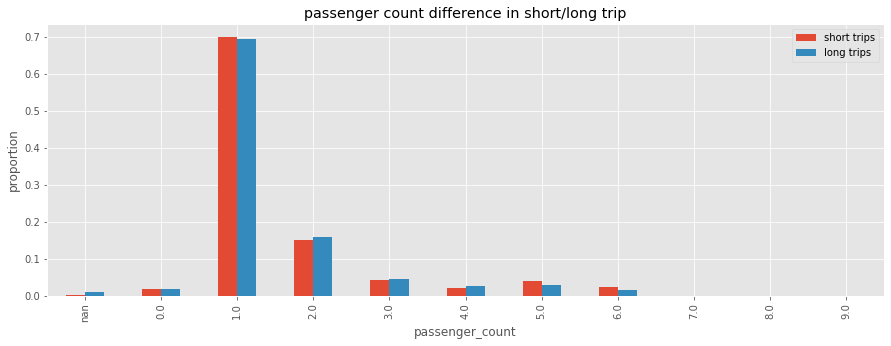

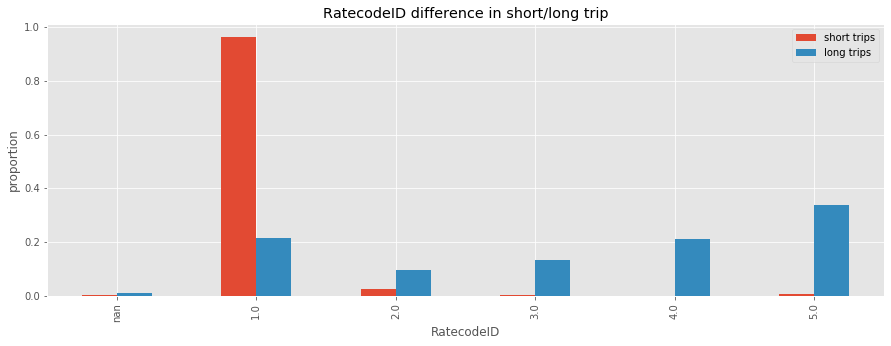

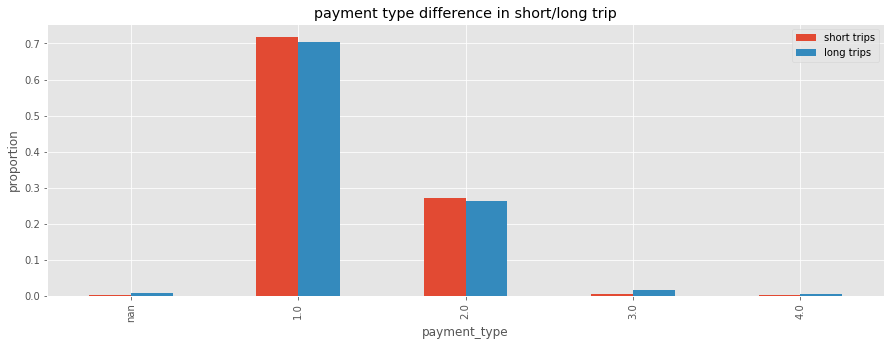

In [211]:
for attr in ["passenger_count", "RatecodeID", "payment_type"]:
    diff_short_long_trip_on(attr, rpr="proportion", kind='bar')

## Passengers
    * In both short and long distance trips, 1 person passenger is most likely. 

## Rates
    1. Standard rate
    2. JFK
    3. Newark
    4. Nassau or Westchester
    5. Negotiated fare
    6. Group ride

## Payment Types
    1. Credit Card
    2. Cash
    3. No charge
    4. Dispute
    5. Unknown
    6. Voided Trip
    

## Helper Codes

In [212]:
def diff_short_long_trip_on_time():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

In [213]:
def diff_short_long_trip_on(attr, rpr="count", kind='bar'):
    df_q3_short = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance < 30 \
                                    GROUP BY '+attr, nyc_database)
    df_q3_long = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance >= 30 \
                                    GROUP BY '+attr, nyc_database)
    if rpr == "proportion":
        s = np.sum(df_q3_short['count'].values)
        df_q3_short['proportion'] = [float(x)/s for x in df_q3_short['count']]
        s = np.sum(df_q3_long['count'].values)
        df_q3_long['proportion'] = [float(x)/s for x in df_q3_long['count']]
    
    df_q3 = df_q3_short.merge(df_q3_long, on=attr, suffixes=["_short", "_long"]) \
                        .rename(columns={rpr+"_short":"short trips", rpr+"_long":"long trips"}) 
    ax = df_q3.plot(x=attr, y=['short trips', 'long trips'], kind=kind, figsize=(15,5))
    ax.set_ylabel(rpr)
    ax.set_title(attr.replace("_", " ")+" difference in short/long trip")

# Discoveries

1. the skyport should be somewhere near upper_east and midtown.
2. it should run between JFK, Newark from 9 am to 10 pm
3. how much should it be?
    - how much more efficient is it? Taxi takes 45 min to 1 hour.(depending on traffic)
    - there are flat rates for air ports($52 for JFK, 18 miles)... Uber would charge $90 can't compete with that

To be clear, the job is to travel up to at least 60 miles on a single charge, with a cruise speed of 150 mph

Efficiency = speed/cost






# Further Explorations with Pandas

Here, we are using random sample at size of 10,000 to do more complex data analysis.


In [199]:
df_tdf = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, total_amount\
                        FROM yellow_taxi ORDER BY random() LIMIT 10000', nyc_database)


Converting datatypes of pickup/dropoff times from string to datetime and adding trip_duration column to df_dtf.

In [200]:
df_tdf['tpep_pickup_datetime'] = pd.to_datetime(df_tdf['tpep_pickup_datetime'])
df_tdf['tpep_dropoff_datetime'] = pd.to_datetime(df_tdf['tpep_dropoff_datetime'])

df_tdf.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
trip_distance                   float64
total_amount                    float64
dtype: object

In [255]:
df_tdf['trip_duration'] = df_tdf['tpep_dropoff_datetime']-df_tdf['tpep_pickup_datetime']
df_tdf['duration_min'] = df_tdf['trip_duration'].dt.total_seconds()/60
df_tdf['trip_speed'] = df_tdf['trip_distance'] / df_tdf['duration_min']*60
df_tdf.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,total_amount,trip_duration,duration_min,trip_speed
0,2019-05-18 12:51:13,2019-05-18 13:03:28,2.13,16.56,00:12:15,12.250000,10.432653
1,2019-06-04 21:49:22,2019-06-04 22:09:58,4.27,25.56,00:20:36,20.600000,12.436893
2,2019-01-13 13:10:42,2019-01-13 13:19:45,1.90,9.80,00:09:03,9.050000,12.596685
3,2019-08-10 15:57:11,2019-08-10 16:49:45,18.14,66.42,00:52:34,52.566667,20.705136
4,2019-01-21 14:29:23,2019-01-21 14:32:10,0.59,7.80,00:02:47,2.783333,12.718563


In [321]:
# Efficiency: cost/distance, cost/time, cost/speed

df_tdf['cost_dist'] = df_tdf['total_amount']/df_tdf['trip_distance']
df_tdf['cost_time'] = df_tdf['total_amount']/df_tdf['duration_min']
df_tdf['cost_speed'] = df_tdf['total_amount']/df_tdf['trip_speed']
df_tdf.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,total_amount,trip_duration,duration_min,trip_speed,cost_dist,cost_time,cost_speed
0,2019-05-18 12:51:13,2019-05-18 13:03:28,2.13,16.56,00:12:15,12.250000,10.432653,7.774648,1.351837,1.587324
1,2019-06-04 21:49:22,2019-06-04 22:09:58,4.27,25.56,00:20:36,20.600000,12.436893,5.985948,1.240777,2.055176
2,2019-01-13 13:10:42,2019-01-13 13:19:45,1.90,9.80,00:09:03,9.050000,12.596685,5.157895,1.082873,0.777982
3,2019-08-10 15:57:11,2019-08-10 16:49:45,18.14,66.42,00:52:34,52.566667,20.705136,3.661521,1.263538,3.207900
4,2019-01-21 14:29:23,2019-01-21 14:32:10,0.59,7.80,00:02:47,2.783333,12.718563,13.220339,2.802395,0.613277


In [492]:
# filtering out abnormalities
df_tdf = df_tdf[df_tdf['duration_min'] < 300]

In [493]:
df_tdf.describe()

,trip_distance,total_amount,trip_duration,duration_min,trip_speed,cost_dist,cost_time,cost_speed
count,9881.000000,9881.000000,9881,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000
mean,3.006471,18.949866,0 days 00:14:29.381034,14.489684,12.076780,12.021664,1.836965,2.114962
std,3.937480,14.737408,0 days 00:11:44.352705,11.739212,39.336176,92.720866,9.075888,20.402202
min,0.010000,3.300000,0 days 00:00:03,0.050000,0.038829,0.860759,0.047674,0.001875
25%,1.000000,11.150000,0 days 00:06:44,6.733333,7.245426,6.152516,1.100461,1.078636
50%,1.630000,14.690000,0 days 00:11:24,11.400000,9.857143,8.545918,1.357188,1.577061
75%,3.010000,20.300000,0 days 00:18:32,18.533333,13.521127,11.760000,1.757676,2.328879
max,47.260000,222.250000,0 days 03:20:53,200.883333,3360.000000,6636.000000,474.000000,2024.285897


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x8f4acb110>,
      dtype=object)

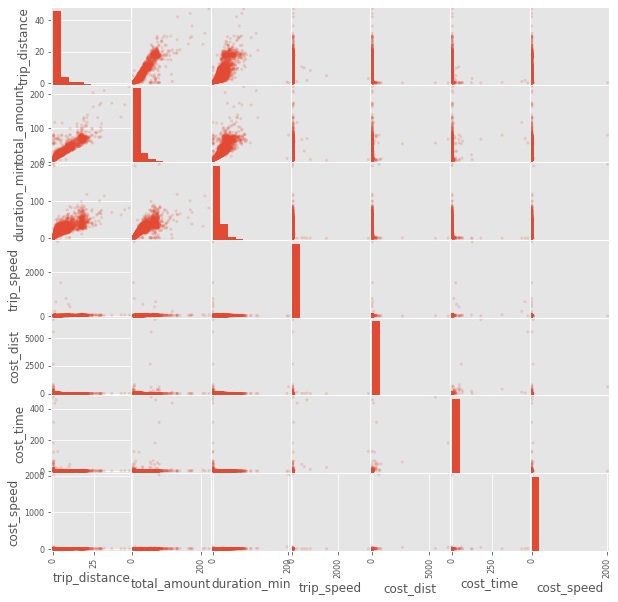

In [494]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_tdf, alpha=0.2, figsize=(10,10))

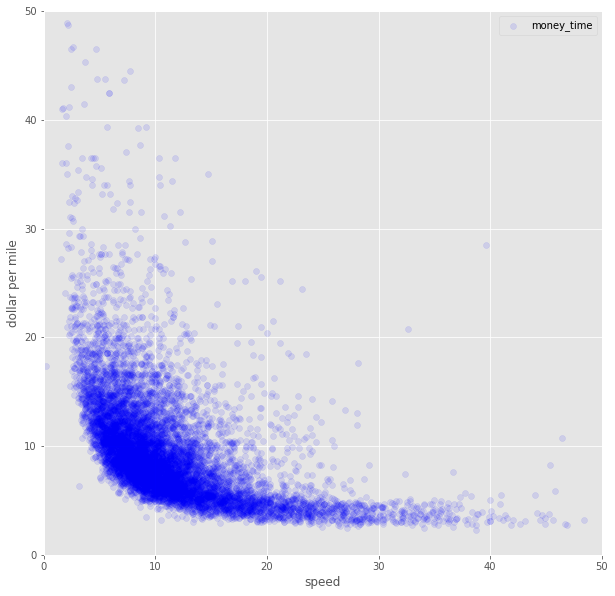

In [510]:
# Dollar per Mile VS SPEED: AS Speed goes up Dollar per mile goes down. 

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_tdf['trip_speed'], df_tdf['cost_dist'], color='b', label='money_time', alpha=0.1)
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xlabel('speed')
ax.set_ylabel('dollar per mile')

ax.legend()
# plot a point for Uber Air

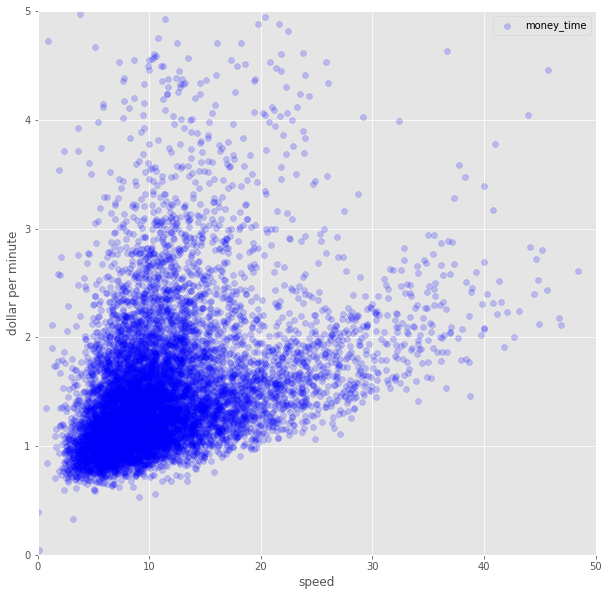

In [504]:
# Dollar per Distance VS SPEED: AS Speed goes up Dollar per mile goes down. 

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_tdf['trip_speed'], df_tdf['cost_time'], color='b', label='money_time', alpha=0.2)
ax.set_xlim(0, 50)
ax.set_ylim(0, 5)
ax.set_xlabel('speed')
ax.set_ylabel('dollar per minute')

ax.legend()
# plot a point for Uber Air

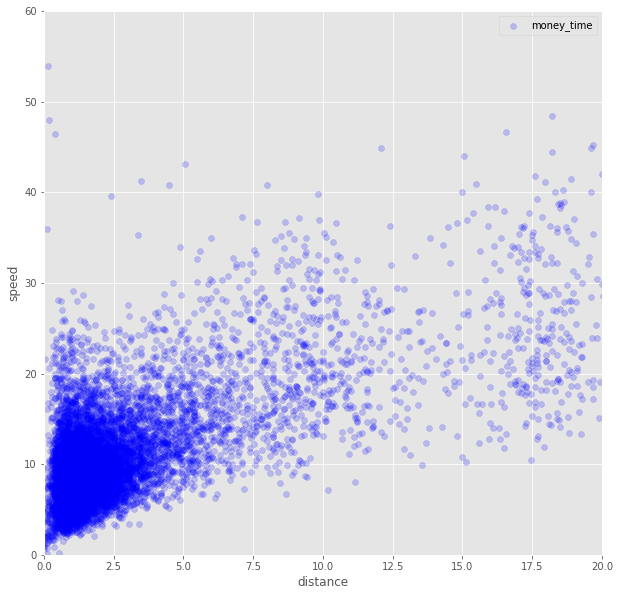

In [509]:
# 

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_tdf['trip_distance'], df_tdf['trip_speed'], color='b', label='money_time', alpha=0.2)
ax.set_xlim(0, 20)
ax.set_ylim(0, 60)
ax.set_xlabel('distance')
ax.set_ylabel('speed')

ax.legend()
# plot a point for Uber Air

Here we can see the average use case of Yellow Taxi in NYC.

* Mean Trip Distance: 3 miles
* Mean Trip Cost: 19 dollars
* Mean Trip Duration: 18 minutes
* Mean Trip Speed: 12 mph

Customers use Yellow Taxi to get to other locations approximately 3 miles away and commit 18 minutes at 19 dollars. 

* Burn Rate = Roughly 1 dollar/minute.
* cost/distance = 6 dollars/mile
* Efficiency???

Next, we'll look at the data for specific airport locations.

In [214]:
5*18

90

In [77]:
df_pu.head()

,LocationID,PUcount
0,NaN,1
1,1.0,8324
2,2.0,100
3,3.0,1906
4,4.0,134598


In [79]:
df_do.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocationID  263 non-null    float64
 1   DOcount     264 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.2 KB


In [331]:
df_jfk = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, total_amount\
                        FROM yellow_taxi WHERE (PULocationID = 132 OR DOLocationID =132)', nyc_database)


In [336]:
df_ewr = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, total_amount\
                        FROM yellow_taxi WHERE (PULocationID = 1 OR DOLocationID =1)', nyc_database)


In [340]:
df_lga = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, total_amount\
                        FROM yellow_taxi WHERE (PULocationID = 138 OR DOLocationID = 138)', nyc_database)


In [344]:
df_jfk['tpep_pickup_datetime'] = pd.to_datetime(df_jfk['tpep_pickup_datetime'])
df_jfk['tpep_dropoff_datetime'] = pd.to_datetime(df_jfk['tpep_dropoff_datetime'])

df_jfk.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
total_amount                    float64
dtype: object

In [346]:
df_jfk['trip_duration'] = df_jfk['tpep_dropoff_datetime']-df_jfk['tpep_pickup_datetime']
df_jfk['duration_min'] = df_jfk['trip_duration'].dt.total_seconds()/60
df_jfk['trip_speed'] = df_jfk['trip_distance'] / df_jfk['duration_min']*60

In [399]:
# eliminating abnormalities
# 10 < total_amount < 500
# 15 min < duration_min < 10 hrs
# 10 mph < trip_speed < 200 mph

df_jfk = df_jfk[df_jfk['total_amount'] < 500]

In [400]:
df_jfk.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount,trip_duration,duration_min,trip_speed
count,2.512294e+06,2.512576e+06,2.512294e+06,2.512576e+06,2.512576e+06,2.512576e+06,2512576,2.512576e+06,2.512576e+06
mean,1.622064e+00,1.781621e+01,1.767932e+00,1.390771e+02,1.452416e+02,6.533778e+01,0 days 00:47:03.851017,4.706418e+01,2.460210e+01
std,1.226027e+00,4.026216e+00,6.909373e-01,3.348037e+01,6.623380e+01,1.722468e+01,0 days 00:15:51.565783,1.585943e+01,7.901365e+00
min,0.000000e+00,4.200000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.030000e+01,0 days 00:25:01,2.501667e+01,1.000000e+01
25%,1.000000e+00,1.650000e+01,1.000000e+00,1.320000e+02,1.070000e+02,5.892000e+01,0 days 00:34:43,3.471667e+01,1.846239e+01
50%,1.000000e+00,1.785000e+01,2.000000e+00,1.320000e+02,1.320000e+02,6.636000e+01,0 days 00:44:06,4.410000e+01,2.342331e+01
75%,2.000000e+00,1.928000e+01,2.000000e+00,1.320000e+02,1.880000e+02,7.367000e+01,0 days 00:56:10,5.616667e+01,2.989859e+01
max,9.000000e+00,5.430900e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.993000e+02,0 days 07:11:11,4.311833e+02,1.465007e+02


In [394]:
df_jfk.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount,trip_duration,duration_min,trip_speed
count,2.515566e+06,2.515849e+06,2.515566e+06,2.515849e+06,2.515849e+06,2.515849e+06,2515849,2.515849e+06,2.515849e+06
mean,1.621882e+00,1.781791e+01,1.768368e+00,1.390737e+02,1.452573e+02,6.521435e+01,0 days 00:47:03.795978,4.706327e+01,2.460327e+01
std,1.225611e+00,4.058510e+00,6.925621e-01,3.347450e+01,6.624318e+01,1.786414e+01,0 days 00:15:52.335864,1.587226e+01,7.902329e+00
min,0.000000e+00,4.200000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.750400e+02,0 days 00:25:01,2.501667e+01,1.000000e+01
25%,1.000000e+00,1.650000e+01,1.000000e+00,1.320000e+02,1.070000e+02,5.892000e+01,0 days 00:34:42,3.470000e+01,1.846384e+01
50%,1.000000e+00,1.785000e+01,2.000000e+00,1.320000e+02,1.320000e+02,6.636000e+01,0 days 00:44:06,4.410000e+01,2.342466e+01
75%,2.000000e+00,1.928000e+01,2.000000e+00,1.320000e+02,1.880000e+02,7.367000e+01,0 days 00:56:10,5.616667e+01,2.989976e+01
max,9.000000e+00,5.430900e+02,9.900000e+01,2.650000e+02,2.650000e+02,9.606800e+02,0 days 07:11:11,4.311833e+02,1.465007e+02


* AVG distance: 17 miles
* AVG duration: 47 minutes
* AVG cost: $ 65
* AVG speed: 24 mph


In [412]:
df_jfk_dc = df_jfk.drop(['passenger_count', 'PULocationID', 'DOLocationID', 'trip_duration'], axis=1)


In [418]:
df_jfk_sample = df_jfk_dc.sample(10000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x26fedc2d0>,
      dtype=object)

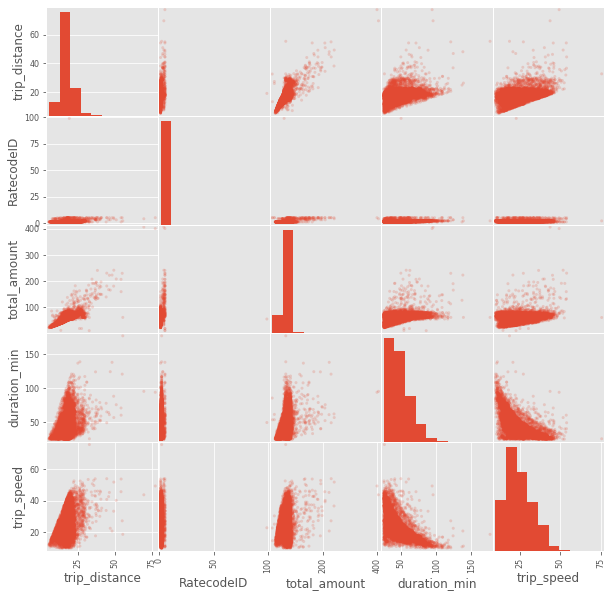

In [419]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_jfk_sample, alpha=0.2, figsize=(10,10))

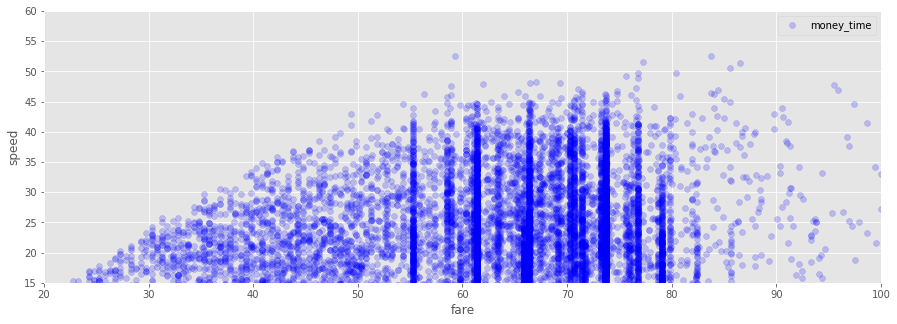

In [441]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_jfk_sample['total_amount'], df_jfk_sample['trip_speed'], color='b', label='money_time', alpha=0.2)
# ax.plot(df_q3_long['passenger_count'], df_q3_long['count'], color='r', label='long distance')
ax.set_xlim(20, 100)
ax.set_ylim(15, 60)
ax.set_xlabel('fare')
ax.set_ylabel('speed')

# ax.axvline(y=150, linestyle='--')

ax.legend()
# plot a point for Uber Air

In [447]:
df_18 = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, RatecodeID, PULocationID, DOLocationID, total_amount\
                        FROM yellow_taxi WHERE (trip_distance > 17 AND trip_distance < 19) ORDER BY random() LIMIT 10000', nyc_database)


In [449]:
df_18['tpep_pickup_datetime'] = pd.to_datetime(df_18['tpep_pickup_datetime'])
df_18['tpep_dropoff_datetime'] = pd.to_datetime(df_18['tpep_dropoff_datetime'])
df_18['trip_duration'] = df_18['tpep_dropoff_datetime']-df_18['tpep_pickup_datetime']
df_18['duration_min'] = df_18['trip_duration'].dt.total_seconds()/60
df_18['trip_speed'] = df_18['trip_distance'] / df_18['duration_min']*60


In [450]:
df_18.describe()

,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount,trip_duration,duration_min,trip_speed
count,10000.000000,9935.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,1.000000e+04
mean,17.935661,1.990337,140.822400,138.423300,69.706574,0 days 00:54:41.161400,54.686023,inf
std,0.534810,0.541519,41.286752,69.010741,11.715331,0 days 01:36:56.414970,96.940250,NaN
min,17.010000,1.000000,1.000000,1.000000,-63.800000,0 days 00:00:00,0.000000,7.211282e-01
25%,17.500000,2.000000,132.000000,90.000000,61.420000,0 days 00:35:06,35.100000,1.868159e+01
50%,17.900000,2.000000,132.000000,132.000000,69.420000,0 days 00:45:11.500000,45.191667,2.382161e+01
75%,18.370000,2.000000,132.000000,170.000000,73.700000,0 days 00:57:27,57.450000,3.073120e+01
max,18.990000,5.000000,265.000000,265.000000,219.960000,0 days 23:59:22,1439.366667,inf


In [470]:
# 10 < trip_speed < 150
# standard rate only
df_18 = df_18[df_18['RatecodeID'] == 1]


In [471]:
df_18.describe()

,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount,trip_duration,duration_min,trip_speed
count,1073.000000,1073.0,1073.000000,1073.000000,1073.000000,1073,1073.000000,1073.000000
mean,17.997130,1.0,139.589935,122.339236,61.657307,0 days 00:42:43.965517,42.732759,27.567967
std,0.573624,0.0,46.894646,79.730695,10.194863,0 days 00:13:37.750721,13.629179,7.761439
min,17.010000,1.0,4.000000,1.000000,-56.800000,0 days 00:21:53,21.883333,10.473142
25%,17.500000,1.0,132.000000,55.000000,55.800000,0 days 00:32:33,32.550000,21.622368
50%,17.990000,1.0,132.000000,112.000000,60.920000,0 days 00:39:46,39.766667,27.284526
75%,18.500000,1.0,138.000000,185.000000,66.360000,0 days 00:49:34,49.566667,32.969758
max,18.990000,1.0,264.000000,265.000000,122.300000,0 days 01:45:11,105.183333,50.270270


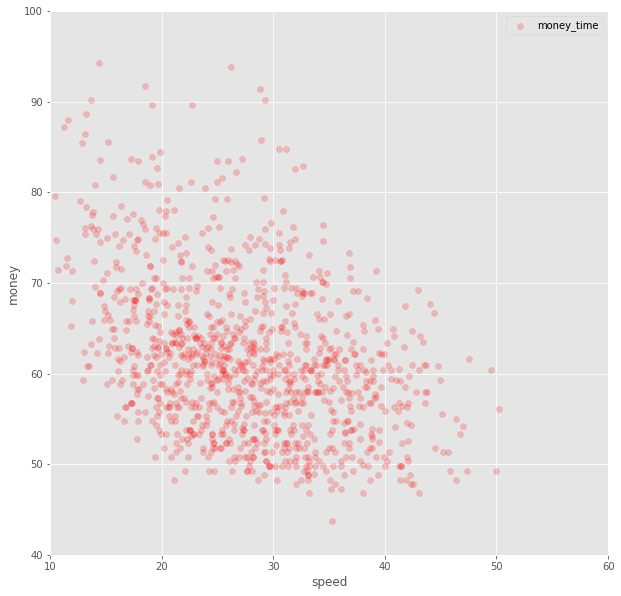

In [479]:
# MONEY VS SPEED

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_18['trip_speed'], df_18['total_amount'], color='r', label='money_time', alpha=0.2)
ax.set_xlim(10, 60)
ax.set_ylim(40, 100)
ax.set_xlabel('speed')
ax.set_ylabel('money')

# ax.axvline(y=150, linestyle='--')

ax.legend()
# plot a point for Uber Air

Uber Air can get to JFK in 7 min 12 sec. (if 74mph, 14:36)
Yellow Taxi's average trip duration for 18 mile distance is 42 minuts.

If I get cost/distance___ in 7 min

* Yellow taxi's cost/distance = 6 dollars/mile

Uber says it's 5 dollars/mile. So it's cheaper in that sense.
Where can I get the price of speed?

Uber Air will cost $90 for trip to JFK.
Yellow Taxi's flat rate to JFK.

The company expects the cost of operating a helicopter will be close to $700 per flight hour, so flying in one of these vehicles is likely to be a lot pricier than an UberX ride.



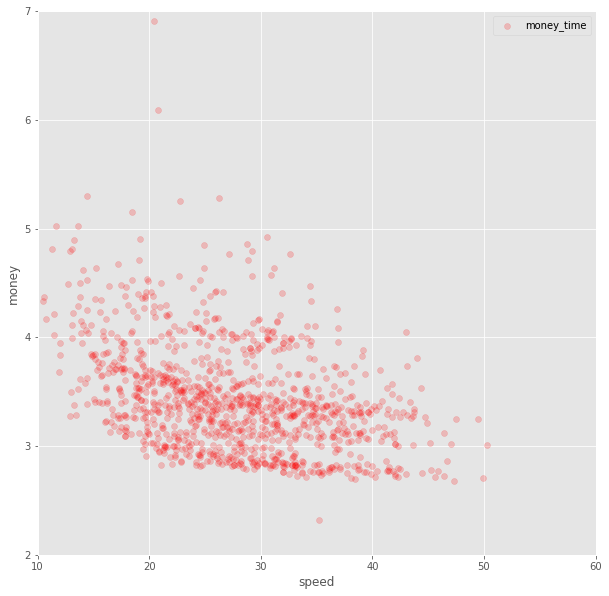

In [480]:
# MONEY VS SPEED

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_18['trip_speed'], (df_18['total_amount']/df_18['trip_distance']), color='r', label='money_time', alpha=0.2)
ax.set_xlim(10, 60)
ax.set_ylim(2, 7)
ax.set_xlabel('speed')
ax.set_ylabel('money')

# ax.axvline(y=150, linestyle='--')

ax.legend()
# plot a point for Uber Air

### Manhattan to Airports

#### JFK
* Distance: 18 Miles

#### LaGuardia
* Distance: 18 Miles

#### Newark
* Distance: 9 Miles

### Between Airports

#### JFK to Newark
* Distance: 21 Miles

#### Newark to Laguardia
* Distance: 17 Miles

#### Laguardia to JFK
* Distance: 10 Miles




In [349]:
df_jfk.sort_values('trip_speed', ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount,trip_duration,duration_min,trip_speed
1028385,2019-05-15 07:53:18,2019-05-15 07:53:18,1.0,18.40,2.0,132,230,73.67,0 days,0.0,inf
786827,2019-04-20 17:26:25,2019-04-20 17:26:25,3.0,0.01,5.0,132,264,82.80,0 days,0.0,inf
221408,2019-01-29 07:17:44,2019-01-29 07:17:44,1.0,24.10,1.0,132,228,85.80,0 days,0.0,inf
673827,2019-04-08 16:12:17,2019-04-08 16:12:17,1.0,16.20,2.0,162,132,71.75,0 days,0.0,inf
168970,2019-01-22 08:13:13,2019-01-22 08:13:13,1.0,17.80,2.0,132,211,67.34,0 days,0.0,inf
...,...,...,...,...,...,...,...,...,...,...,...
3223324,2019-12-30 09:34:41,2019-12-30 09:34:41,2.0,0.00,1.0,132,264,47.80,0 days,0.0,NaN
3224079,2019-12-30 12:08:13,2019-12-30 12:08:13,1.0,0.00,2.0,132,264,52.80,0 days,0.0,NaN
3224080,2019-12-30 12:08:14,2019-12-30 12:08:14,1.0,0.00,2.0,132,264,52.80,0 days,0.0,NaN
3224861,2019-12-30 13:16:23,2019-12-30 13:16:23,1.0,0.00,1.0,132,264,3.30,0 days,0.0,NaN


In [367]:
df_jfk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105446 entries, 0 to 3227663
Data columns (total 11 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   tpep_pickup_datetime   datetime64[ns] 
 1   tpep_dropoff_datetime  datetime64[ns] 
 2   passenger_count        float64        
 3   trip_distance          float64        
 4   RatecodeID             float64        
 5   PULocationID           int64          
 6   DOLocationID           int64          
 7   total_amount           float64        
 8   trip_duration          timedelta64[ns]
 9   duration_min           float64        
 10  trip_speed             float64        
dtypes: datetime64[ns](2), float64(6), int64(2), timedelta64[ns](1)
memory usage: 284.3 MB


In [386]:
df_jfk['trip_speed'].max()

146.50065530799475

In [341]:
df_lga.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_amount
0,2019-01-01 00:19:55,2019-01-01 00:57:56,1.0,12.30,1.0,138,50,49.06
1,2019-01-01 00:27:06,2019-01-01 00:51:51,1.0,9.33,1.0,68,138,35.56
2,2019-01-01 00:48:10,2019-01-01 01:36:58,1.0,31.57,1.0,138,138,83.80
3,2019-01-01 00:39:58,2019-01-01 00:58:58,2.0,8.90,1.0,138,224,41.31
4,2019-01-01 00:07:45,2019-01-01 00:34:12,4.0,9.60,1.0,138,239,43.26


In [335]:
len(df_jfk)

3227664

# For Hire Vehicles

In [35]:
df = pd.read_csv("data/fhvhv/fhvhv_nyc.2019-07.csv", nrows=10)
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02884,2019-07-01 00:12:33,2019-07-01 00:25:00,228,89,NaN
1,HV0003,B02884,2019-07-01 00:41:26,2019-07-01 00:51:21,97,188,NaN
2,HV0003,B02870,2019-07-01 00:18:50,2019-07-01 00:32:48,81,220,NaN
3,HV0005,B02510,2019-07-01 00:05:12,2019-07-01 00:19:26,78,69,NaN
4,HV0005,B02510,2019-07-01 00:29:01,2019-07-01 00:45:50,69,239,NaN


In [38]:
j, chunksize = 1, 100000
for month in range(2,13):
    fp = "data/fhvhv/fhvhv_nyc.2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['dropoff_datetime']]
        df.index += j
        df.to_sql('fhvhv', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

In [216]:
df_fhvhv = pd.read_sql_query('SELECT hvfhs_license_num, pickup_datetime, dropoff_datetime, PULocationID, DOLocationID\
                        FROM fhvhv ORDER BY random() LIMIT 10000', nyc_database)

In [217]:
df_fhvhv.head()

,hvfhs_license_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
0,HV0005,2019-02-14 06:45:34,2019-02-14 07:04:46,13,230
1,HV0003,2019-04-06 23:18:26,2019-04-06 23:28:26,240,254
2,HV0003,2019-12-02 07:09:24,2019-12-02 07:18:55,114,107
3,HV0003,2019-05-08 07:59:14,2019-05-08 08:43:29,23,67
4,HV0003,2019-12-28 00:50:50,2019-12-28 00:56:36,36,36


In [229]:
df_fhvhv['pickup_datetime'] = pd.to_datetime(df_fhvhv['pickup_datetime'])
df_fhvhv['dropoff_datetime'] = pd.to_datetime(df_fhvhv['dropoff_datetime'])


In [231]:
df_fhvhv['duration'] = df_fhvhv['dropoff_datetime']-df_fhvhv['pickup_datetime']

In [244]:
df_fhvhv['duration_min'] = df_fhvhv['duration'].dt.total_seconds()/60

In [246]:
df_fhvhv['speed'] = df_fhvhv['distance']

dtype('float64')

In [243]:
test.describe()

count    10000.000000
mean        19.050347
std         13.795096
min        -22.050000
25%          9.650000
50%         15.375000
75%         24.387500
max        197.183333
Name: duration, dtype: float64

In [237]:
df_fhvhv['PULocationID'].value_counts()

138    169
79     167
132    156
61     143
231    142
      ... 
207      1
99       1
27       1
265      1
1        1
Name: PULocationID, Length: 251, dtype: int64

In [203]:
df_tdf_long = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, total_amount\
                        FROM yellow_taxi WHERE trip_distance > 34 ORDER BY random() LIMIT 10000', nyc_database)


In [319]:
df_tdf_long['tpep_pickup_datetime'] = pd.to_datetime(df_tdf_long['tpep_pickup_datetime'])
df_tdf_long['tpep_dropoff_datetime'] = pd.to_datetime(df_tdf_long['tpep_dropoff_datetime'])
df_tdf_long['trip_duration'] = df_tdf_long['tpep_dropoff_datetime']-df_tdf_long['tpep_pickup_datetime']
df_tdf_long['duration_min'] = df_tdf_long['trip_duration'].dt.total_seconds()/60
df_tdf_long['duration_min'] = df_tdf_long['duration_min'].round(2)
df_tdf_long['trip_speed'] = df_tdf_long['trip_distance'] / df_tdf['duration_min']*60

df_tdf_long.head()

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,total_amount,trip_duration,duration_min,trip_speed
0,2019-08-07 07:20:50,2019-08-07 08:26:37,35.80,160.42,01:05:47,65.78,175.346939
1,2019-07-23 02:04:23,2019-07-23 02:54:28,36.70,129.29,00:50:05,50.08,106.893204
2,2019-07-08 23:32:49,2019-07-09 00:27:44,40.15,146.54,00:54:55,54.92,266.187845
3,2019-05-18 08:54:41,2019-05-18 10:07:06,41.30,124.30,01:12:25,72.42,47.140140
5,2019-10-28 10:06:22,2019-10-28 12:26:23,35.64,145.61,02:20:01,140.02,433.459459


In [320]:
df_tdf_long.describe()

,trip_distance,total_amount,trip_duration,duration_min,trip_speed
count,9571.000000,9571.000000,9571,9571.000000,9571.000000
mean,43.674553,180.681508,0 days 01:23:57.226831,83.953758,272.354639
std,14.968526,82.398057,0 days 01:59:38.951219,119.649172,193.102326
min,34.010000,-304.540000,0 days 00:00:03,0.050000,-44.877419
25%,36.290000,136.420000,0 days 00:54:52.500000,54.875000,131.618617
50%,39.090000,169.700000,0 days 01:06:28,66.470000,215.337793
75%,46.160000,216.960000,0 days 01:24:26,84.430000,358.748246
max,701.300000,1170.300000,1 days 21:29:27,2729.450000,1000.000000


In [313]:
df_tdf_long[df_tdf_long['trip_speed']< 5000]


In [318]:
df_tdf_long.sort_values('trip_speed', ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,total_amount,trip_duration,duration_min,trip_speed
756,2019-05-14 22:52:00,2019-05-14 23:45:09,35.00,208.30,00:53:09,53.15,1000.000000
3822,2019-03-15 20:41:26,2019-03-15 20:41:47,49.10,145.30,00:00:21,0.35,998.644068
4123,2019-12-05 12:45:08,2019-12-05 15:08:14,53.81,61.42,02:23:06,143.10,998.536082
5054,2019-01-14 12:48:07,2019-01-14 13:44:38,49.91,239.18,00:56:31,56.52,998.200000
780,2019-05-14 15:52:55,2019-05-14 17:31:59,46.00,246.05,01:39:04,99.07,997.590361
...,...,...,...,...,...,...,...
2441,2019-04-11 21:37:24,2019-04-11 22:49:21,35.90,109.92,01:11:57,71.95,1.535409
1428,2019-11-07 22:23:07,2019-11-07 23:25:20,36.15,123.30,01:02:13,62.22,1.524405
7172,2019-09-15 18:33:01,2019-09-15 19:30:13,36.17,136.54,00:57:12,57.20,1.520724
1511,2019-06-04 14:39:33,2019-06-04 15:58:33,35.03,156.92,01:19:00,79.00,1.474499


In [338]:
df_tdf_long.describe()

,trip_distance,total_amount,trip_duration,duration_min,trip_speed
count,9571.000000,9571.000000,9571,9571.000000,9571.000000
mean,43.674553,180.681508,0 days 01:23:57.226831,83.953758,272.354639
std,14.968526,82.398057,0 days 01:59:38.951219,119.649172,193.102326
min,34.010000,-304.540000,0 days 00:00:03,0.050000,-44.877419
25%,36.290000,136.420000,0 days 00:54:52.500000,54.875000,131.618617
50%,39.090000,169.700000,0 days 01:06:28,66.470000,215.337793
75%,46.160000,216.960000,0 days 01:24:26,84.430000,358.748246
max,701.300000,1170.300000,1 days 21:29:27,2729.450000,1000.000000


In [290]:
test = df_tdf_long.loc[df_tdf_long['trip_speed'].idxmax()]
test['trip_speed'].dtype

dtype('float64')

In [283]:
df_tdf_long.loc[df_tdf_long['trip_speed'].idxmax()]

tpep_pickup_datetime     2019-02-10 19:38:34
tpep_dropoff_datetime    2019-02-10 20:34:17
trip_distance                           34.6
total_amount                          119.06
trip_duration                0 days 00:55:43
duration_min                           55.72
trip_speed                               inf
Name: 1112, dtype: object

In [273]:
distance_count = df_tdf_long['trip_distance'].value_counts()
distance_count

36.20     53
36.30     49
36.70     49
35.20     47
35.30     47
          ..
74.08      1
122.47     1
68.06      1
46.51      1
54.56      1
Name: trip_distance, Length: 2664, dtype: int64

In [ ]:
distance_count

In [274]:
distance_count = distance_count.to_frame('counts').reset_index().rename(columns = {'index': 'trip_distance'})
distance_count





,trip_distance,counts
0,36.20,53
1,36.30,49
2,36.70,49
3,35.20,47
4,35.30,47
...,...,...
2659,74.08,1
2660,122.47,1
2661,68.06,1
2662,46.51,1


In [277]:
distance_count = distance_count[distance_count.trip_distance < 0]
distance_count

,trip_distance,counts


In [271]:
df_tdf_long[df_tdf_long['trip_distance'] < 0]

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,total_amount,trip_duration,duration_min,trip_speed


Above table shows the average use case of Yellow Taxi for long distance trips in NYC.

* Mean Trip Distance: 44 miles
* Mean Trip Cost: 182 dollars
* Mean Trip Duration: 1 hour 24 minutes

Customers use Yellow Taxi to get to other locations approximately 44 miles away and commit 1 hour and 24 minutes(84 minutes) at 182 dollars.

Burn Rate = Roughly 2.2 dollars/minute. (cost/time)
cost/distance = $4.13

VTOL would need to be at least 2.2 times faster(something like this)

Speed of Average Yellow Taxi = 44 miles / 84 minute * 60 min/hour = 31.4 mph

Uber Air's announced rate at the moment is 5 dollar/mile.
It's 220 dollars for an average long distance trip(44 miles), which is 38 dollars more than average cost of long distance travel.

And since the VTOL is not hobbled by rotor drag during cruise, it can operate at speeds from 350 to 400 mph compared to about 125 mph for most helicopters. This aircraft will also fly two to three times farther with a given payload, so its productivity in transporting cargo is much higher than the helicopter's.

add speed


In [427]:
182/44

4.136363636363637